## Intro
This python notebook will be dedicated to do some preliminary analyses on the datasets that we have. Our initial goal is to look at data from the 2$\sigma$ competition:
https://www.kaggle.com/c/two-sigma-financial-news/data\

Since that isn't available until around Aug. 5, we'll use data from Aaron7sun:
https://www.kaggle.com/aaron7sun/stocknews/

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import matplotlib.pyplot as plt # plotting
from functools import reduce # to merge dataframes

%matplotlib inline

In [2]:
# read in the datasets
combNews   = pd.read_csv('datasets/dailyStockNews/Combined_News_DJIA.csv', parse_dates=['Date']) # has top 25 headlines from reddit news file
djia       = pd.read_csv('datasets/dailyStockNews/DJIA_table.csv', parse_dates=['Date']) # stock data

# merge datasets
dfList     = [combNews, djia]
dfMerged   = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), dfList)

# I need another copy of the dataframe
dfMergedTwo = dfMerged.copy(deep=True)

In [3]:
# create a function that fixes up the text
def normalize_text(txt):
    # get list of stop words
    stop_words = nltk.corpus.stopwords.words('english')
    # define the tokenizer function
    wpt = nltk.WordPunctTokenizer()
    # tokenize the text; remove punctuation, useless words, etc.
    tokens = wpt.tokenize(txt)
    txtFiltered = ' '.join([token for token in tokens if token not in stop_words])
    
    return txtFiltered

/home/daoranje/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


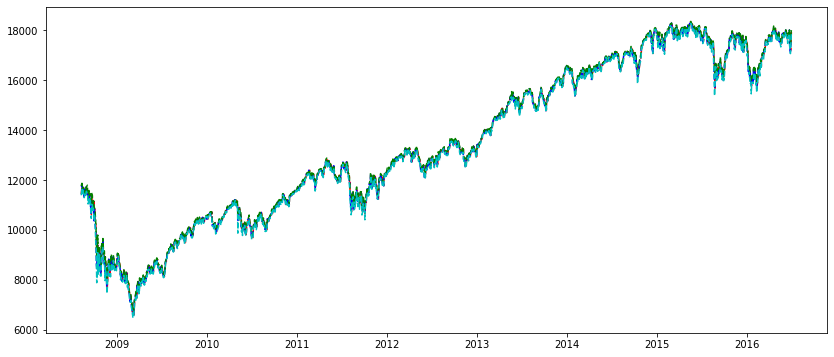

In [4]:
plt.figure(figsize=(14,6))
plt.plot(dfMerged['Date'], dfMerged['Open'], 'r--')
plt.plot(dfMerged['Date'], dfMerged['Adj Close'], 'b--')
plt.plot(dfMerged['Date'], dfMerged['High'], 'g--')
plt.plot(dfMerged['Date'], dfMerged['Low'], 'c--')

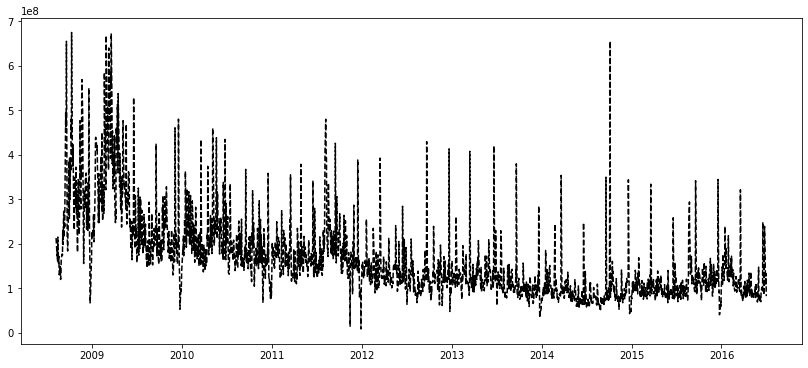

In [5]:
plt.figure(figsize=(14,6))
plt.plot(dfMerged['Date'], dfMerged['Volume'], 'k--')

All numbers, barring "Volume", follow the same patterns (visually speaking). We can get an R<sup>2</sup> score to find out.

From here, I think we should start looking at NLTK to infer the market pattern--there isn't much else to analyze outside of this anyway."

## Sentiment analysis
Let's use NLTK's sentiment analysis \"SentimentIntensityAnalyzer\" to determine if a headline is negative or positive"

In [6]:
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SIA()

# get the column names for top news
header   = [i for i in dfMerged.columns if 'Top' in i]
features = []
# get the sentiment scores for each column
for i in header:
    counter = 0
    compoundSentiment = []
    features.append(i + 'Sentiment')
    for j in dfMerged[i]:
        try:
            polarityScore = sia.polarity_scores(normalize_text(j))
            compoundSentiment.append(polarityScore['compound'])
        except: # one cell is empty
            compoundSentiment.append(0)
    dfMerged[i + 'Sentiment'] = compoundSentiment

## Create model of all sentiments vs label using logistic regression

In [7]:
# create the dataframes for the datas
# index the data such that the features correspond to the day before label
X = dfMerged[features].iloc[:-1]
y = dfMerged['Label'].iloc[1:]

# Make training set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.25, random_state=2)

# set the model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()

# fit model
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.5291750503018109
Precision: 0.5440806045340051
Recall: 0.8029739776951673


/home/daoranje/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Do KNN with sentiments vs label
A concern is that, as we increase dimensionality, the distance of each neighbor increases. I think we might need to decrease the number of news we use per observation

In [8]:
# create the dataframes for the datas
# index the data such that the features correspond to the day before label
X = dfMerged[features[0:3]].iloc[:-1] # let's just use a subset of features for now
y = dfMerged['Label'].iloc[1:]

# Make training set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.25, random_state=2)

# set the model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# pick the number of neighbors... let's do sqrt(nrow)
knn = KNeighborsClassifier(n_neighbors=31)

# fit model
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.5352112676056338
Precision: 0.5579268292682927
Recall: 0.6802973977695167


## Try KNN by combining all news
For feature selection, maybe we shouldn't look at how each individual news affects the regression. After all, this data is just whatever is popular and it's silly to have different types of news correspond to a particular feature (like most popular headline). Therefore, let's combine all news from the day and use each key from the sentiments as the features. That way, we ahve something like \"the market will go up when the amount of positive news is this much and the amount of negatives is that much

In [9]:
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# sia = SIA()

# get the column names for top news
header   = [i for i in dfMergedTwo.columns if 'Top' in i]
combinedTextSentiments = []
sentimentHeader = ['neg', 'pos', 'neu', 'compound']
dfMergedTwo.head()
# loop through dataframe
for i in range(len(dfMergedTwo)):
    combinedText = normalize_text(' '.join([str(dfMergedTwo.iloc[i][k]) for k in header]))
    combinedTextSentiments.append([sia.polarity_scores(combinedText)[m] for m in sentimentHeader])
    
# convert the sentiment data into a df
sentimentDf = pd.DataFrame(data=combinedTextSentiments, columns=sentimentHeader)
dfMergedSentiment = pd.concat([dfMergedTwo, sentimentDf], axis=1)

In [10]:
# create the dataframes for the datas
# index the data such that the features correspond to the day before label
newSentimentHeader = ['pos', 'neg', 'neu']
X = dfMergedSentiment[newSentimentHeader].iloc[:-1] # let's just use a subset of features for now
y = dfMergedSentiment['Label'].iloc[1:]

# Make training set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.25, random_state=2)

# set the model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# pick the number of neighbors... let's start with 7
knn = KNeighborsClassifier(n_neighbors=31, weights='distance')

# fit model
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.4909456740442656
Precision: 0.5266666666666666
Recall: 0.587360594795539


Combining all news definitely does worse than not combining all of them...